# Sliding-Window Object Detection

In this exercise we will implement a simple car detector. To accomplish this, we will first implement a feature descriptor similar to the Histogram of Oriented Gradients (HOG). Then using the features computed for (small) image patches with fixed size, we will train a support vector machine (SVM) classifier, to classify whether the input patch corresponds to a car. 

In the end, given a test image with arbitary shape, we will run our classifier over the image in a sliding window (patch) fashion. We will generate detections at the places where the classifier is very confident that the patch contains a car.

You may refer to the original HOG paper, or the following two tutorials, in case you want to freshen up your knowledge on HOG a little bit:

- N. Dalal and B. Triggs: Histograms of oriented gradients for human detection. CVPR 2005. http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
- https://www.learnopencv.com/histogram-of-oriented-gradients/
- http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [66]:
%matplotlib notebook
import os
import glob
import cv2
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import imageio
import sklearn.svm
import scipy.ndimage

def plot_multiple(images, titles=None, colormap='gray', 
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()

### Dataset

To train our classifier, we will use the *UIUC dataset* (http://cogcomp.org/Data/Car/). Download and extract it, then use the `load_dataset` function to pre-load images (modify `dataset_dir` to the path where you extracted the dataset). The function will return three lists, containing images for positive training sample, negative training sample, and test set.

In [67]:
def load_dataset(dataset_dir):
    def natural_sort_key(s):
        return [float(t) if t.isdigit() else t for t in re.split('([0-9]+)', s)]
    
    def load_images(*path_parts):
        paths = glob.glob(os.path.join(dataset_dir, *path_parts))
        return [imageio.imread(p) for p in sorted(paths, key=natural_sort_key)]
        
    train_images_pos = load_images('TrainImages', 'pos-*.pgm')
    
    train_images_neg = load_images('TrainImages', 'neg-*.pgm')
    test_images = load_images('TestImages', 'test-*.pgm')
    assert (len(train_images_pos) == 550 and 
            len(train_images_neg) == 500 and
            len(test_images) == 170)
    return train_images_pos, train_images_neg, test_images

### CHANGE THIS TO THE DATASET PATH ###
dataset_dir = '/Users/chidergrosser/Desktop/Computer Vision/exercise2/CarData'
train_images_pos, train_images_neg, test_images = load_dataset(dataset_dir)

## HOG-like Descriptor
First we want to implement a simple HOG-like descriptor `hoglike_descriptor()` which takes an image and computes the corresponding HOG-like representation. The function should take in following arguments:

- `image`: the grayscale image,
- `cell_size`: the size of each HOG-like cell in both dimensions, 
- `n_bins` the number of bins for the gradient orientation, 

The output should be a three dimensional array. The first two dimensions are the spatial indices of the HOG cell. The third dimension describes the orientation bins of the HOG descriptor. Each cell has to be independently $L_2$ normalized to 1. Note that the original HOG paper describes a more elaborate two-stage normalization scheme, that is why we call our version here a "HOG-like" descriptor.

When the dimensions of the images are not a multiple of the `cell_size`, discard the remaining pixels to the right and to the bottom of the image.

In [68]:
def image_gradients_polar(image):
    filter_kernel = np.array([[-1,0,1]], dtype=np.float32)
    dx = scipy.ndimage.convolve(image, filter_kernel, mode='reflect')
    dy = scipy.ndimage.convolve(image, filter_kernel.T, mode='reflect')
    magnitude = np.hypot(dx, dy)
    direction = np.arctan2(dy, dx) # between -pi and +pi
    return magnitude, direction

def hoglike_descriptor(image, cell_size=8, n_bins=16):
    #print(image.shape[0])
    image = image.astype(np.float32)/255
    # get the gradient of an image 
    grad_mag, grad_dir = image_gradients_polar(np.sqrt(image+1e-4))
    #print(grad_dir.shape[0])

    # YOUR CODE HERE
    iteration_height=int(image.shape[0]/cell_size)
    iteration_width=int(image.shape[1]/cell_size)
    #print(iteration)
    angle=np.pi/n_bins
    hog=np.zeros((iteration_height,iteration_width,n_bins))
    for i in range(iteration_height):
        for j in range(iteration_width):
            for k in range(n_bins):
                
                cell=grad_dir[cell_size*i:(i+1)*cell_size][cell_size*j:cell_size*(j+1)]
                
                x=((cell>k*angle) & (cell<(k+1)*angle)).astype(int)
                s1=np.sum(x)
                y=((cell > k*angle-np.pi) & (cell< (k+1)*angle-np.pi)).astype(int)
                s2=np.sum(y)
                
                s=s1+s2
                hog[i][j][k]=s
        
    #raise NotImplementedError()
    #print(hog.shape)
    # Normalization
    bin_norm = np.linalg.norm(hog, axis=-1, keepdims=True)
    return hog / (bin_norm + 1e-4)

A simple way to visualize HOG features is to plot the 90° rotated gradient vector for each bin, with length propotional to the value of the bin. The function `plot_hog` implements this. The 90° rotation makes the image easier to interpret intuitively, because then the lines will approximate the rough shape of the image content.

In [69]:
def draw_line(img, pt1, pt2, color, thickness=1):
    pt1 = tuple(np.round(pt1*16).astype(int))
    pt2 = tuple(np.round(pt2*16).astype(int))
    cv2.line(img, pt1, pt2, color=color, shift=4, 
             thickness=thickness, lineType=cv2.LINE_AA)

def plot_hog_cell(image_roi, hog_cell):
    """Visualize a single HOG cell."""
    output_size = image_roi.shape[0]
    half_bin_size = np.pi / len(hog_cell) / 2
    tangent_angles = np.linspace(0, np.pi, len(hog_cell), endpoint=False) + np.pi/2
    center = output_size / 2
    
    for cell_value, tangent_angle in zip(hog_cell, tangent_angles):
        cos_sin = np.array([np.cos(tangent_angle), np.sin(tangent_angle)])
        offset = cell_value * output_size * cos_sin *0.5
        draw_line(image_roi, center - offset, center + offset, 
                  color=(249,129,42), thickness=3)

# plot the 90 degree rotated gradient vector for each bin, with length proportional to the value of the bin
def plot_hog(image, hog, cell_size=8):
    upsample_factor = 96 / cell_size
    result = cv2.resize(image, (0, 0), fx=upsample_factor, fy=upsample_factor,
                        interpolation=cv2.INTER_NEAREST)
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
    result = (result.astype(np.float32)*0.6).astype(np.uint8)

    for y, x in np.ndindex(*hog.shape[:2]):
        yx = np.array([y, x])
        y0_out, x0_out = (yx * cell_size * upsample_factor).astype(int)
        y1_out, x1_out = ((yx+1) * cell_size * upsample_factor).astype(int)
        result_roi = result[y0_out:y1_out, x0_out:x1_out]
        plot_hog_cell(result_roi, hog[y, x])
    return result

<IPython.core.display.Javascript object>


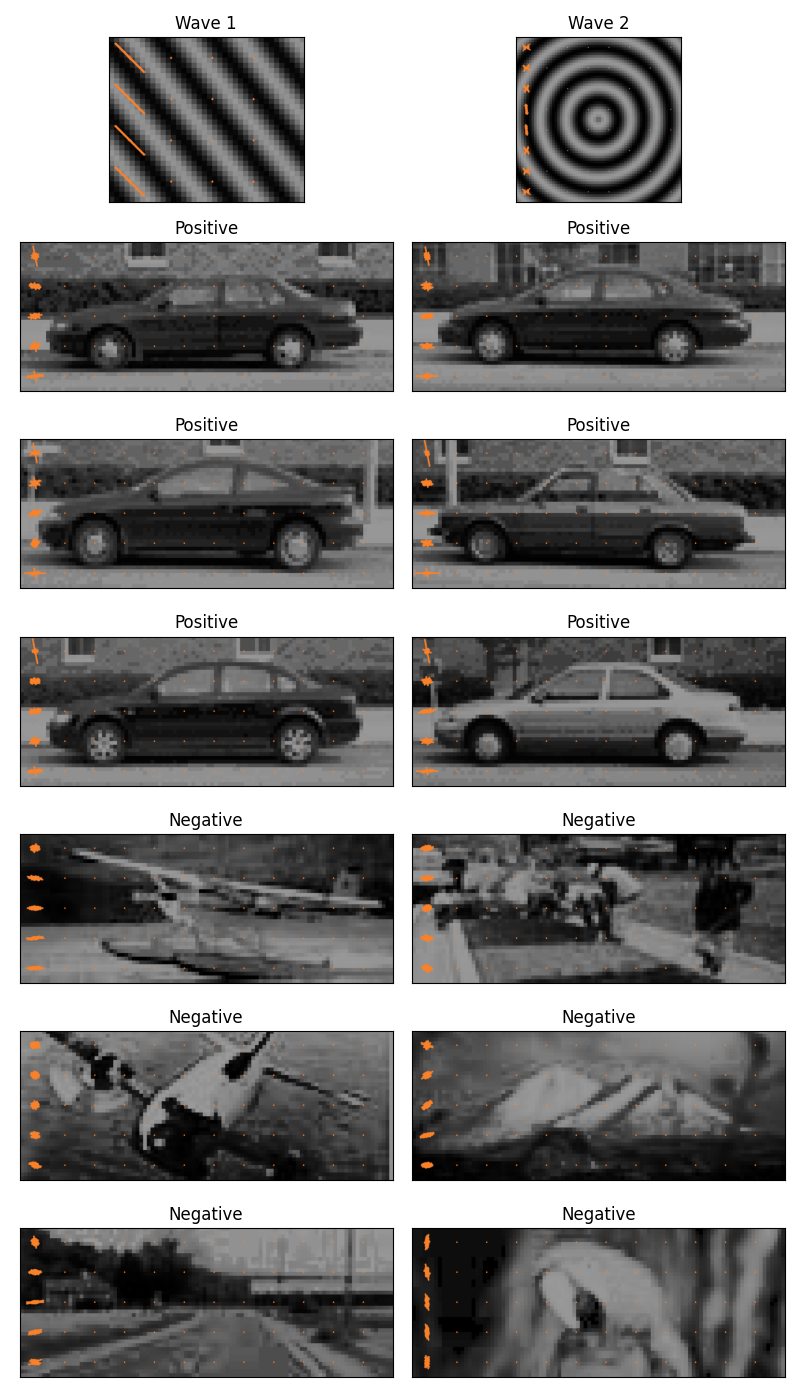

In [70]:
# Two simple wave images are here to help understand the visualization
waves = [imageio.imread('sine.png'), imageio.imread('circular_sine.jpg')]
images = waves + train_images_pos[:6] + train_images_neg[:6]
hogs = [hoglike_descriptor(image) for image in images]
hog_plots = [plot_hog(image, hog) for image, hog in zip(images, hogs)]
titles = ['Wave 1', 'Wave 2'] + ['Positive']*6 + ['Negative']*6
plot_multiple(hog_plots, titles, max_columns=2, imheight=2, imwidth=4, share_axes=False)

Describe what you see. Can you spot any interesting HOG-cells in the positive and negative example that could be useful for telling cars apart from non-cars? 

My Answer:
The HOG-cell for positive examples mainly has the horizontal orientation especially in the car body part but the others do not.

## Support Vector Machine for Classifying Image Windows

We now want to train a classifier in our HOG-like feature space to tell cars and non-cars apart. We use a kernel SVM with Gaussian (radial basis function, RBF) kernel for this. 

Given the HOG representation of an image patch, the classifier should predict if the image patch corresponds to a car. The classifier will then be used to detect objects in new test images using sliding windows.

In [71]:
def train_svm(positive_hog_windows, negative_hog_windows):
    svm = sklearn.svm.SVC(C=10, probability=True, kernel='rbf', gamma='scale')
    hog_windows = np.concatenate([positive_hog_windows, negative_hog_windows])
    svm_input = hog_windows.reshape([len(hog_windows),-1])
    svm_target = np.concatenate((
            np.full(len(positive_hog_windows), 1, dtype=np.float32),
            np.full(len(negative_hog_windows), 0, dtype=np.float32)))
    svm.fit(svm_input, svm_target)
    return svm

def predict_svm(svm, hog_window):
    """Return the confidence of classifying as a car."""
    return svm.predict_proba(hog_window.reshape(1, -1))[:, 1]

In [72]:
start_time = time.time()
print('Computing features...')
positive_hog_windows = [hoglike_descriptor(im) for im in train_images_pos]
negative_hog_windows = [hoglike_descriptor(im) for im in train_images_neg]
duration = time.time()-start_time     
print(f'Done. Used {duration:.2f} s.')

start_time = time.time()
print('Training SVM...')
svm = train_svm(positive_hog_windows, negative_hog_windows)
duration = time.time()-start_time
print(f'Done. Used {duration:.2f} s.')

Computing features...
Done. Used 34.81 s.
Training SVM...
Done. Used 1.32 s.


## Sliding Window-Based Detection

Now implement sliding window classification in the function `get_score_map`. It takes as input the trained classifier object `svm`, the HOG representation of a query image and `window_shape`, the shape of the sliding window (height, width). 

The function should slide a window over the HOG representation, compute the classification score for each window location, and return a score map. Notice that the score map will not have the same shape as the input HOG representation, it will be smaller because the full window needs to fit within the image (This is similar to the border effects from the earlier lectures, when sliding a convolutional kernel without padding lead to a smaller output image than the input).

Use `predict_svm(svm, hog_window)` to get the classification score for a HOG window. 

In [15]:
def get_score_map(svm, hog, window_shape):
    # YOUR CODE HERE
    # hog: hog is HOG representation of a query image ; window shape: the shape of sliding window
    # score map is a matrix which documents the score in every sliding window
    #print(window_shape) #(5,12)
    #print(hog.shape) #(14,26,16)
    #print(svm)
    score_map=np.zeros((hog.shape[0]-window_shape[0]+1,hog.shape[1]-window_shape[1]+1))
    # score_map shape (10,15,)
    for i in range(score_map.shape[0]):
        for j in range(score_map.shape[1]):
            hog_window=hog[i:i+window_shape[0],j:j+window_shape[1]]
            score_map[i][j]=predict_svm(svm,hog_window)
    #raise NotImplementedError()
    return score_map

The next step is to convert the score map to actual detections. Implement the function `score_map_to_detections` which returns the indices as well as the values of scores that are higher than certain `threshold`.

In [73]:
def score_map_to_detections(score_map, threshold):
    # YOUR CODE HERE
    xs=[]
    ys=[]
    scores=[]
    for i in range(score_map.shape[0]):
        for j in range(score_map.shape[1]):
            if score_map[i][j]>threshold:
                xs.append(j)
                ys.append(i)
                scores.append(score_map[i][j])
    #raise NotImplementedError()
    return xs, ys, scores

Finally, we can test our car detector!

In [74]:
import itertools
def draw_detections(image, xs, ys, scores, window_shape, cell_size=8):
    offset_size = 0
    
    #image=np.array(image)
    #image = cv2.UMat(image).get()
    #print(type(image))
    h, w = image.shape[:2]
    scale_out = 5
    output_image = cv2.resize(
        image, (w*scale_out, h*scale_out), interpolation=cv2.INTER_NEAREST)
    if output_image.ndim < 3:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2RGB)
    output_image = (output_image.astype(np.float32)*0.6).astype(np.uint8)
    
    window_size_out = np.array(window_shape[::-1]) * cell_size * scale_out
    color = (197,255,0)
    
    for x, y, score in zip(xs, ys, scores):
        im_p0 = (np.array([x,y]) * cell_size + offset_size) * scale_out
        im_p1 = im_p0 + window_size_out
        cv2.rectangle(output_image, tuple(im_p0),tuple(im_p1),
                      color, thickness=3, lineType=cv2.LINE_AA)
        cv2.putText(output_image, f'{score:.0%}', tuple(im_p0), 
                    cv2.FONT_HERSHEY_COMPLEX, 1.5, color,
                    thickness=2, lineType=cv2.LINE_AA)
    return output_image

<IPython.core.display.Javascript object>


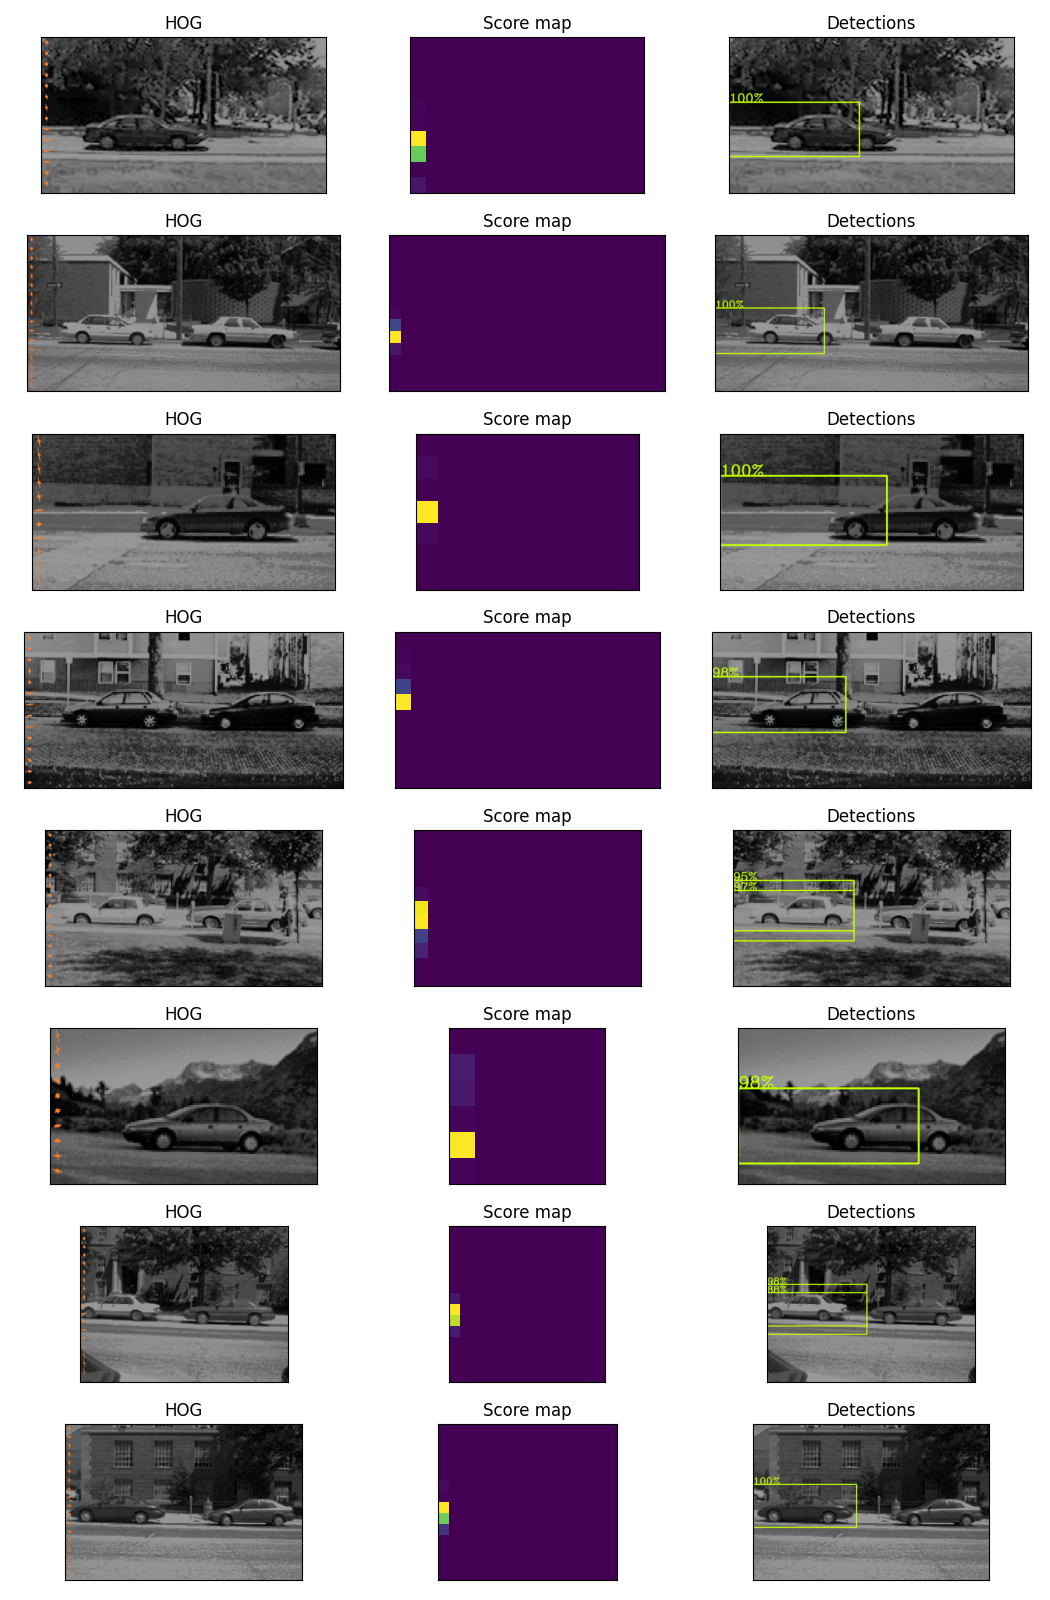

In [75]:
images, titles = [], []
window_shape = positive_hog_windows[0].shape[:2]

for test_image in test_images[:8]:
    hog = hoglike_descriptor(test_image)
    score_map = get_score_map(svm, hog, window_shape)
    xs, ys, scores = score_map_to_detections(score_map, 0.8)
    #print(xs.size)
    detection_image = draw_detections(
        test_image, xs, ys, scores, window_shape)
    
    images += [plot_hog(test_image, hog), score_map, detection_image]
    titles += ['HOG', 'Score map', 'Detections']

plot_multiple(
    images, titles, max_columns=3, 
    imheight=2, imwidth=3.5, colormap='viridis')

How do the results look?

YOUR ANSWER HERE:looks okay

## Non-Maximum Suppression

Sliding window based detectors often give multiple responses for the same target. A way to compensate such effect is to use non-maximum-suppression (NMS) on the score map. NMS simply looks at every pixel of the score map and keeps it only if it is the maximum in its 8-neighborhood (set to 0 otherwise). Implement `nms` which takes a score map, and returns the non-maximum-suppressed one.

In [76]:
def nms(score_map):
    # YOUR CODE HERE
    for i in range(1,score_map.shape[0]-1):
        for j in range(1,score_map.shape[1]-1):
            temp=score_map[i-1:i+1,j-1:j+1]
            temp=temp>score_map[i][j]
            temp.astype(int)
            if np.sum(temp)>0:
                score_map[i][j]=0
                
    return score_map
    #raise NotImplementedError()

<IPython.core.display.Javascript object>


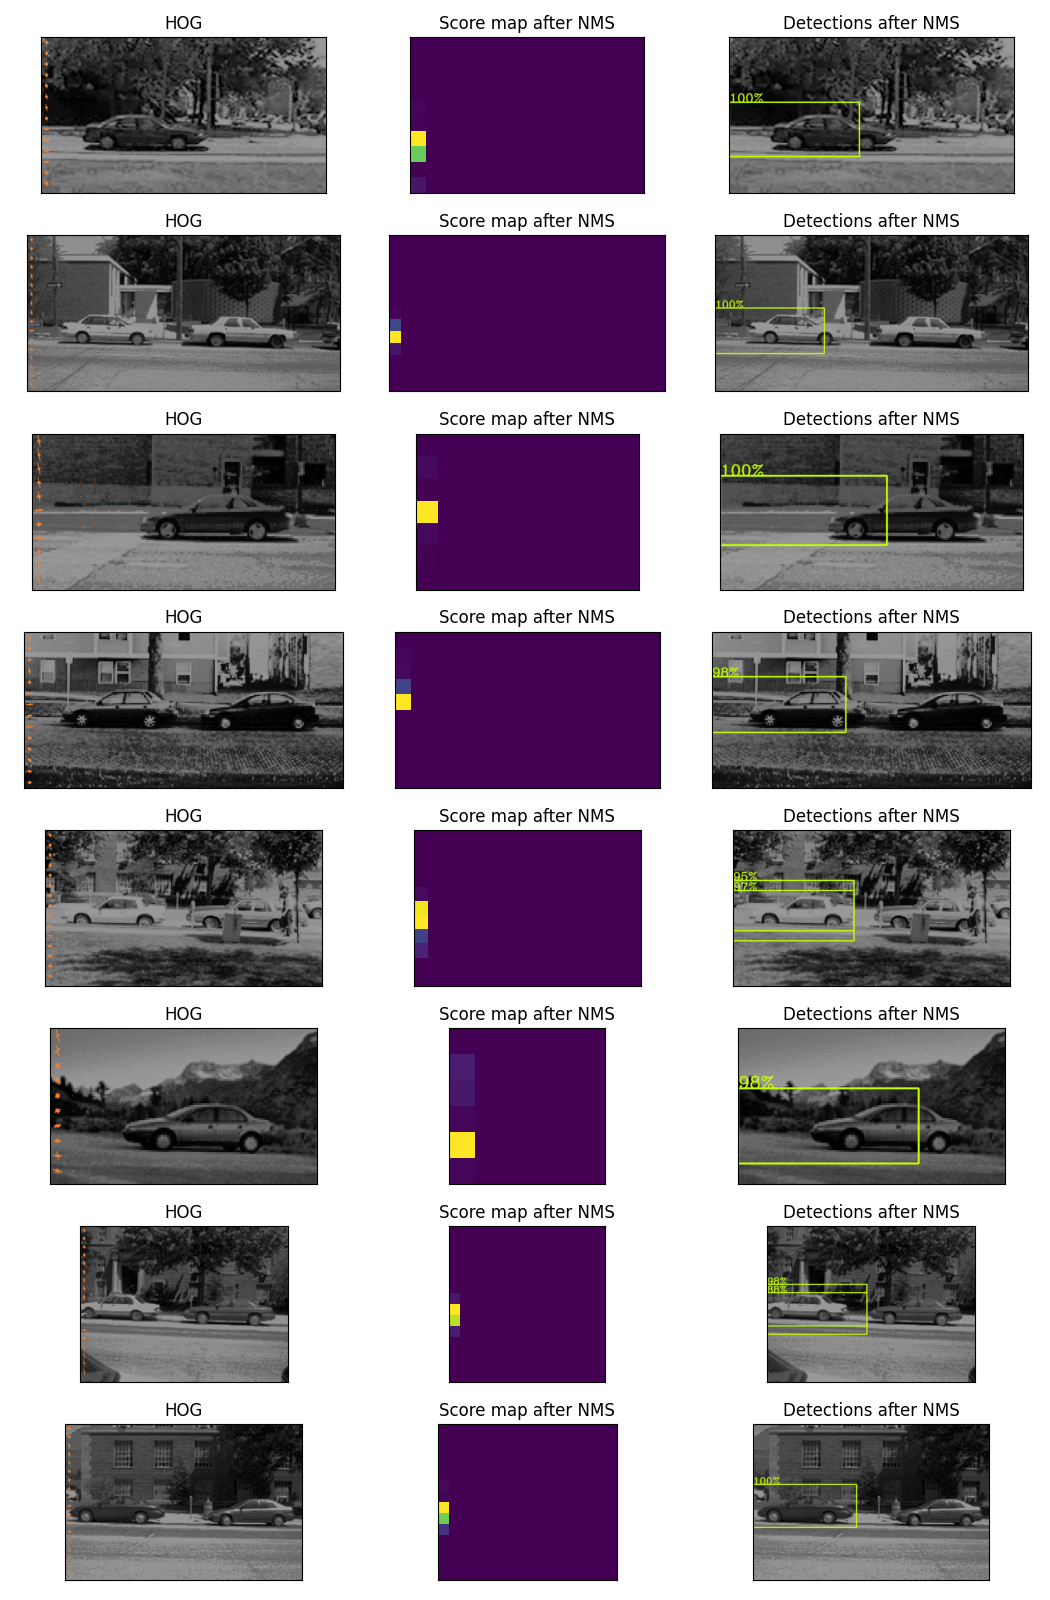

In [77]:
images, titles = [], []
for test_image in test_images[:8]:
    hog = hoglike_descriptor(test_image)
    score_map = nms(get_score_map(svm, hog, window_shape))
    xs, ys, scores = score_map_to_detections(score_map, 0.8)
    detection_image = draw_detections(
        test_image, xs, ys, scores, window_shape)
    
    images += [plot_hog(test_image, hog), score_map, detection_image]
    titles += ['HOG', 'Score map after NMS', 'Detections after NMS']

plot_multiple(
    images, titles, max_columns=3, 
    imheight=2, imwidth=3.5, colormap='viridis')

**Does the result look better? Can you find examples where it fails? Can you imagine a downside of non-maximum-suppression?**

YOUR ANSWER HERE: seems not much better


Let's now evaluate the performance of our detector on the full UIUC test set. The dataset's zip contains a Java-based evaluation program, which we can call from this notebook (lines starting with ! are interpreted as shell commands in Jupyter Notebooks).

With a correct implementation the F-measure should be well above 90%.

In [80]:
def evaluate(test_images, svm, window_shape, descriptor_func=hoglike_descriptor, 
             cell_size=8, threshold=0.8):
    # Write the detections to a file that is understood by the Java-based 
    # evaluation program supplied with the dataset.
    with open('foundLocations.txt', 'w') as f:
        for i, test_image in enumerate(test_images):
            hog = descriptor_func(test_image)
            score_map = nms(get_score_map(svm, hog, window_shape))
            xs, ys, scores = score_map_to_detections(score_map, threshold)

            f.write(f'{i}: ')
            for x,y in zip(xs, ys):
                f.write(f'({y*cell_size}, {x*cell_size}) ')
            f.write('\n')
    
    # Run the evaluation program on our generated file
    !java -classpath $dataset_dir Evaluator $dataset_dir/trueLocations.txt foundLocations.txt
    
    #!java -classpath $/Users/chidergrosser/Desktop/Computer_Vision/exercise2/CarData Evaluator $/Users/chidergrosser/Desktop/Computer_Vision/exercise2/CarData/trueLocations.txt foundLocations.txt  
evaluate(test_images, svm, window_shape, hoglike_descriptor, threshold=0.8)

Error: Could not find or load main class Vision.exercise2.CarData


## [BONUS] Soft Assignment to Multiple Bins and Cells

In our `hoglike_descriptor`, we have used a simple assignment scheme of gradient vector to HOG bins. Each pixel voted for a single gradient orientation bin of a single spatial cell.

Now imagine if a gradient orientation falls on the end of an orientation bin. A small rotation would make it change to its neighboring bin, thus suddenly altering the HOG feature.

Similarly, imagine a pixel near the border between HOG-cells (spatially). A small translation of the object by a few pixels would make this gradient vote in the neighboring cell, again largely changing the features.

To make our descriptor more robust to small rotations and translations, let's replace this simple assignment scheme with a smooth voting. This will distribute the gradient magnitude over neighboring bins and cells.

In particular, we will use trilinear interpolation weights for weighting votes to neighboring bins. This is analogous to bilinear interpolation, but for three dimensional arrays. Remember that our descriptor is a three-dimensional array, and is indexed by two spatial cell indices and an orientation bin index. (If you don't know what bilinear interpolation is, read the first tutorial provided at the beginning of this exercise.)

Implement a `hoglike_descriptor_with_interp` function, which has same functionality and signature with `hoglike_descriptor` implemented earlier, but with simple assignment replaced with soft assignment according to trilinear interpolation weights.

In [ ]:
def hoglike_descriptor_with_interp(image, cell_size=8, n_bins=16):
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # Normalization
    bin_norm = np.linalg.norm(hog, axis=-1, keepdims=True)
    return hog / (bin_norm + 1e-4)

In [ ]:
start_time = time.time()
print('Computing features...')
descriptor_func = hoglike_descriptor_with_interp
positive_hog_windows = [descriptor_func(im) for im in train_images_pos]
negative_hog_windows = [descriptor_func(im) for im in train_images_neg]
duration = time.time()-start_time     
print(f'Done. Used {duration:.2f} s.')

start_time = time.time()
print('Training SVM...')
svm2 = train_svm(positive_hog_windows, negative_hog_windows)
duration = time.time()-start_time
print(f'Done. Used {duration:.2f} s.')

Does it obtain better results?

In [ ]:
evaluate(test_images, svm2, window_shape, 
         hoglike_descriptor_with_interp, threshold=0.8)

YOUR ANSWER HERE

**Congratulations, you have now implemented a car detector! To conclude, let's visualize it on different test images.**

In [ ]:
def to_gray(im):
    if im.ndim < 3:
        return im
    else:
        return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

streetview_images = [imageio.imread(f'streetview{i}.jpg') for i in range(1,4)]
some_uiuc_test_images = test_images[50:101]

input_images = streetview_images + some_uiuc_test_images
detection_images = []

for test_image in input_images:
    hog = hoglike_descriptor_with_interp(to_gray(test_image))
    score_map = nms(get_score_map(svm2, hog, window_shape))
    xs, ys, scores = score_map_to_detections(score_map, 0.8)
    detection_image = draw_detections(
        test_image, xs, ys, scores, window_shape)
    detection_images.append(detection_image)

plot_multiple(detection_images[:3], max_columns=1, imheight=2, imwidth=6)
plot_multiple(detection_images[3:], max_columns=4, imheight=2, imwidth=3.5)